# Main Imports

In [2]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import json # Export dictionary of tuned parameters.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning.
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier, StackingClassifier



# Evaluation metrics import
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
)

from sklearn.metrics import classification_report

# Models import
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Visualisations import
import seaborn as sns
import matplotlib.pyplot as plt

# Global variables

In [3]:
#This is for data, which is most important split.
RANDOM_STATE = 42 

# Task 1.1 Exploration

# Task 1.2 Workflow related functions

In [4]:
def load_data(file_path):
    """
    Load a dataset from a specified file path. Supports gzip-compressed files.
    """
    return pd.read_csv(file_path, compression='gzip')

# Train Data
def train_data(data, model, label_col, test_size=0.2, random_state=42, standardize=True, with_pca=False, n_pca_components=10):
    """ 
    Preprocesses the data, splits it into train and test sets, applies optional standardization and PCA, and trains the specified model.
    Returns the fitted model along with the processed train and test datasets.
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if with_pca:
        pca = PCA(n_components=n_pca_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test) 

    print(f"Training {model.__class__.__name__}...")
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

# Evaluate Model
def evaluate(model, X_test, y_test):
    """
    Evaluates a fitted model on the test data, computing metrics: accuracy, balanced accuracy, F1 score, AUC, and confusion matrix.
    Returns a DataFrame with evaluation metrics and the confusion matrix.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    confusion = confusion_matrix(y_test, y_pred)

    results = {
        "Metric": ["Accuracy", "Balanced Accuracy", "F1 Score", "AUC"],
        "Value": [accuracy, balanced_accuracy, f1, auc_score]
    }
    results_df = pd.DataFrame(results)
    
    return results_df, confusion

# Visualizations related functions

In [5]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    """
    Plots a heatmap for the given confusion matrix with annotations.
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

## Loading the data from the path

In [6]:
file_path = "Datasets/Data 1.csv.gz" 
# Load the dataset
data = load_data(file_path)

# Task 1.2 

In [6]:
label_column = "label"

## list of all models metrics

In [7]:
results = [] 

## LDA without PCA

Linear Discriminant Analysis (LDA) - Without PCA:
Training LinearDiscriminantAnalysis...
              Metric     Value
0           Accuracy  0.700457
1  Balanced Accuracy  0.700674
2           F1 Score  0.632287
3                AUC  0.738854


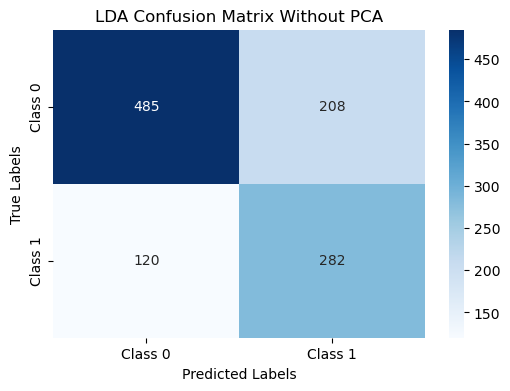

In [8]:
print("Linear Discriminant Analysis (LDA) - Without PCA:")
lda_model = LinearDiscriminantAnalysis()
lda_trained, X_train, X_test, y_train, y_test = train_data(
    data, lda_model, label_col=label_column, standardize=True, with_pca=False
)
lda_results_no_pca, lda_confusion_no_pca = evaluate(lda_trained, X_test, y_test)
print(lda_results_no_pca)
results.append({"Model": "LDA", "With PCA": False, **dict(zip(lda_results_no_pca["Metric"], lda_results_no_pca["Value"]))})
plot_confusion_matrix(lda_confusion_no_pca, labels=["Class 0", "Class 1"], title="LDA Confusion Matrix Without PCA")

## LDA with PCA


Linear Discriminant Analysis (LDA) - With PCA:
Training LinearDiscriminantAnalysis...
              Metric     Value
0           Accuracy  0.943379
1  Balanced Accuracy  0.924452
2           F1 Score  0.917112
3                AUC  0.989849


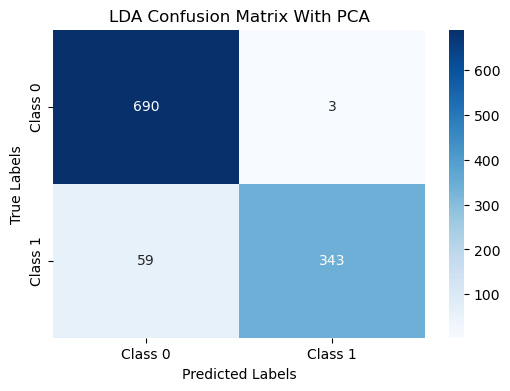

In [9]:
print("\nLinear Discriminant Analysis (LDA) - With PCA:")
lda_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, lda_model, label_col=label_column, standardize=True, with_pca=True, n_pca_components=10
)
lda_results_pca, lda_confusion_pca = evaluate(lda_trained_pca, X_test_pca, y_test_pca)
print(lda_results_pca)
results.append({"Model": "LDA", "With PCA": True, **dict(zip(lda_results_pca["Metric"], lda_results_pca["Value"]))})
plot_confusion_matrix(lda_confusion_pca, labels=["Class 0", "Class 1"], title="LDA Confusion Matrix With PCA")

## Logistic classifier without PCA


Logistic Regression - Without PCA:
Training LogisticRegression...
              Metric     Value
0           Accuracy  0.953425
1  Balanced Accuracy  0.950146
2           F1 Score  0.936646
3                AUC  0.991995


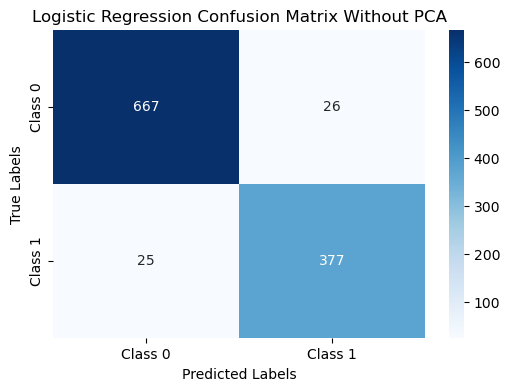

In [10]:
print("\nLogistic Regression - Without PCA:")
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_trained, X_train, X_test, y_train, y_test = train_data(
    data, log_reg_model, label_col=label_column, standardize=True, with_pca=False
)
log_reg_results_no_pca, log_reg_confusion_no_pca = evaluate(log_reg_trained, X_test, y_test)
print(log_reg_results_no_pca)
results.append({"Model": "Logistic Regression", "With PCA": False, **dict(zip(log_reg_results_no_pca["Metric"], log_reg_results_no_pca["Value"]))})
plot_confusion_matrix(log_reg_confusion_no_pca, labels=["Class 0", "Class 1"], title="Logistic Regression Confusion Matrix Without PCA")


## Logistic regression with PCA


Logistic Regression - With PCA:
Training LogisticRegression...
              Metric     Value
0           Accuracy  0.960731
1  Balanced Accuracy  0.954874
2           F1 Score  0.945776
3                AUC  0.991586


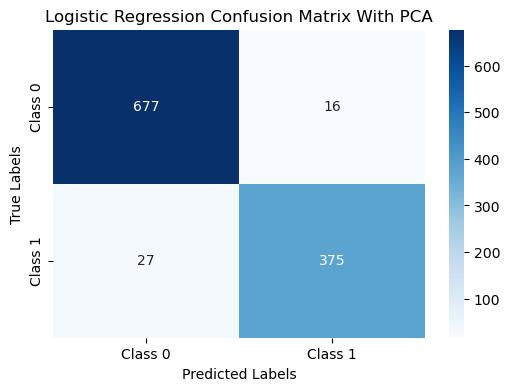

In [11]:
# Logistic Regression with PCA
print("\nLogistic Regression - With PCA:")
log_reg_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, log_reg_model, label_col=label_column, standardize=True, with_pca=True, n_pca_components=10
)
log_reg_results_pca, log_reg_confusion_pca = evaluate(log_reg_trained_pca, X_test_pca, y_test_pca)
print(log_reg_results_pca)
results.append({"Model": "Logistic Regression", "With PCA": True, **dict(zip(log_reg_results_pca["Metric"], log_reg_results_pca["Value"]))})
plot_confusion_matrix(log_reg_confusion_pca, labels=["Class 0", "Class 1"], title="Logistic Regression Confusion Matrix With PCA")

## QDA without PCA


Quadratic Discriminant Analysis (QDA) - Without PCA:
Training QuadraticDiscriminantAnalysis...


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              Metric     Value
0           Accuracy  0.529680
1  Balanced Accuracy  0.541206
2           F1 Score  0.477157
3                AUC  0.541206


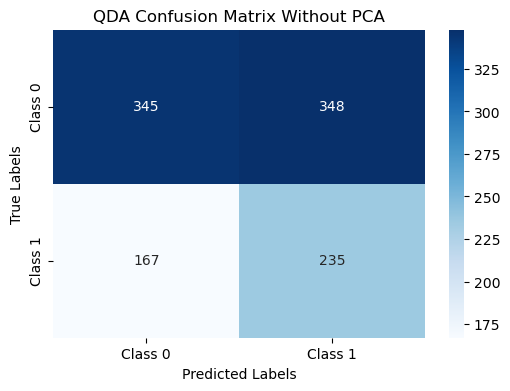

In [12]:
# QDA without PCA
print("\nQuadratic Discriminant Analysis (QDA) - Without PCA:")
qda_model = QuadraticDiscriminantAnalysis()
qda_trained, X_train, X_test, y_train, y_test = train_data(
    data, qda_model, label_col=label_column, standardize=True, with_pca=False
)
qda_results_no_pca, qda_confusion_no_pca = evaluate(qda_trained, X_test, y_test)
print(qda_results_no_pca)
results.append({"Model": "QDA", "With PCA": False, **dict(zip(qda_results_no_pca["Metric"], qda_results_no_pca["Value"]))})
plot_confusion_matrix(qda_confusion_no_pca, labels=["Class 0", "Class 1"], title="QDA Confusion Matrix Without PCA")

## QDA with PCA


Quadratic Discriminant Analysis (QDA) - With PCA:
Training QuadraticDiscriminantAnalysis...
              Metric     Value
0           Accuracy  0.953425
1  Balanced Accuracy  0.945446
2           F1 Score  0.935197
3                AUC  0.989687


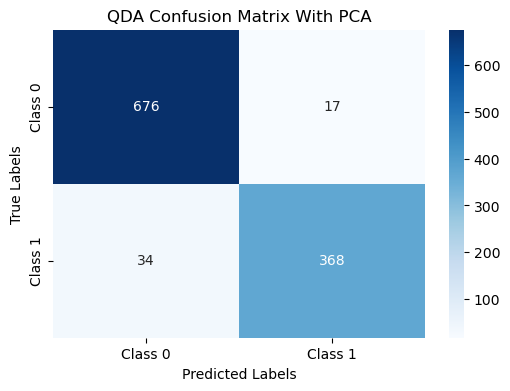

In [13]:
# QDA with PCA
print("\nQuadratic Discriminant Analysis (QDA) - With PCA:")
qda_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, qda_model, label_col=label_column, standardize=True, with_pca=True, n_pca_components=10
)
qda_results_pca, qda_confusion_pca = evaluate(qda_trained_pca, X_test_pca, y_test_pca)
print(qda_results_pca)
results.append({"Model": "QDA", "With PCA": True, **dict(zip(qda_results_pca["Metric"], qda_results_pca["Value"]))})
plot_confusion_matrix(qda_confusion_pca, labels=["Class 0", "Class 1"], title="QDA Confusion Matrix With PCA")

## k-NN without PCA


k-NN - Without PCA:
Training KNeighborsClassifier...
              Metric     Value
0           Accuracy  0.729680
1  Balanced Accuracy  0.666834
2           F1 Score  0.538941
3                AUC  0.714191


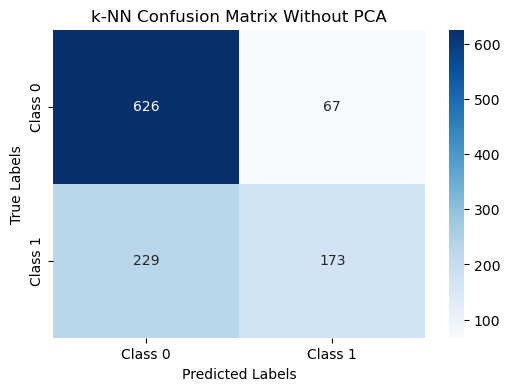

In [14]:
# k-NN without PCA
print("\nk-NN - Without PCA:")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_trained, X_train, X_test, y_train, y_test = train_data(
    data, knn_model, label_col=label_column, standardize=True, with_pca=False
)
knn_results_no_pca, knn_confusion_no_pca = evaluate(knn_trained, X_test, y_test)
print(knn_results_no_pca)
results.append({"Model": "k-NN", "With PCA": False, **dict(zip(knn_results_no_pca["Metric"], knn_results_no_pca["Value"]))})
plot_confusion_matrix(knn_confusion_no_pca, labels=["Class 0", "Class 1"], title="k-NN Confusion Matrix Without PCA")

## k-NN with PCA


k-NN - With PCA:
Training KNeighborsClassifier...
              Metric     Value
0           Accuracy  0.931507
1  Balanced Accuracy  0.914551
2           F1 Score  0.901186
3                AUC  0.971486


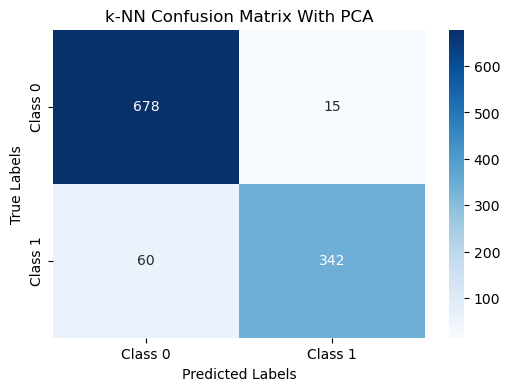

In [15]:
# k-NN with PCA
print("\nk-NN - With PCA:")
knn_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, knn_model, label_col=label_column, standardize=True, with_pca=True, n_pca_components=10
)
knn_results_pca, knn_confusion_pca = evaluate(knn_trained_pca, X_test_pca, y_test_pca)
print(knn_results_pca)
results.append({"Model": "k-NN", "With PCA": True, **dict(zip(knn_results_pca["Metric"], knn_results_pca["Value"]))})
plot_confusion_matrix(knn_confusion_pca, labels=["Class 0", "Class 1"], title="k-NN Confusion Matrix With PCA")

## GBDT without PCA


Gradient Boosting Decision Trees (GBDT) - Without PCA:
Training GradientBoostingClassifier...
              Metric     Value
0           Accuracy  0.948858
1  Balanced Accuracy  0.937660
2           F1 Score  0.927835
3                AUC  0.989834


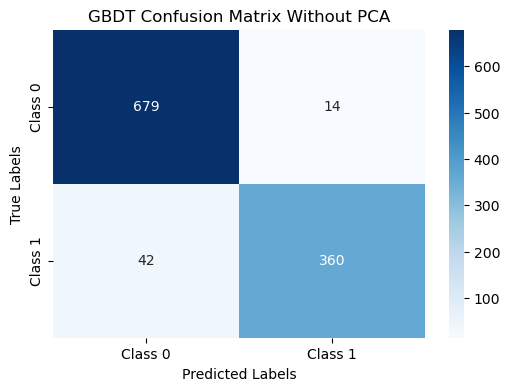

In [16]:
# GBDT without PCA
print("\nGradient Boosting Decision Trees (GBDT) - Without PCA:")
gbdt_model = GradientBoostingClassifier()
gbdt_trained, X_train, X_test, y_train, y_test = train_data(
    data, gbdt_model, label_col=label_column, standardize=False, with_pca=False
)
gbdt_results_no_pca, gbdt_confusion_no_pca = evaluate(gbdt_trained, X_test, y_test)
print(gbdt_results_no_pca)
results.append({"Model": "GBDT", "With PCA": False, **dict(zip(gbdt_results_no_pca["Metric"], gbdt_results_no_pca["Value"]))})
plot_confusion_matrix(gbdt_confusion_no_pca, labels=["Class 0", "Class 1"], title="GBDT Confusion Matrix Without PCA")

## GBDT with PCA


Gradient Boosting Decision Trees (GBDT) - With PCA:
Training GradientBoostingClassifier...
              Metric     Value
0           Accuracy  0.940639
1  Balanced Accuracy  0.929078
2           F1 Score  0.916345
3                AUC  0.984665


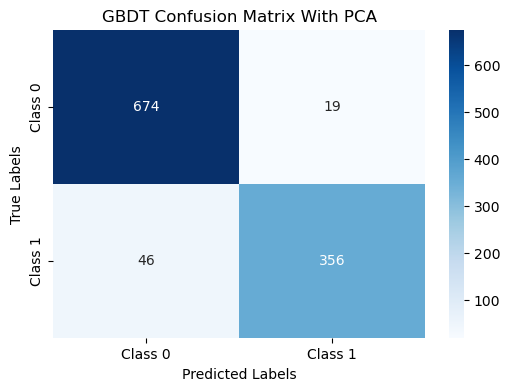

In [17]:
# GBDT with PCA
print("\nGradient Boosting Decision Trees (GBDT) - With PCA:")
gbdt_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, gbdt_model, label_col=label_column, standardize=False, with_pca=True, n_pca_components=10
)
gbdt_results_pca, gbdt_confusion_pca = evaluate(gbdt_trained_pca, X_test_pca, y_test_pca)
print(gbdt_results_pca)
results.append({"Model": "GBDT", "With PCA": True, **dict(zip(gbdt_results_pca["Metric"], gbdt_results_pca["Value"]))})
plot_confusion_matrix(gbdt_confusion_pca, labels=["Class 0", "Class 1"], title="GBDT Confusion Matrix With PCA")

## Random Forest without PCA


Random Forest - Without PCA:
Training RandomForestClassifier...
              Metric     Value
0           Accuracy  0.941553
1  Balanced Accuracy  0.923532
2           F1 Score  0.914894
3                AUC  0.989892


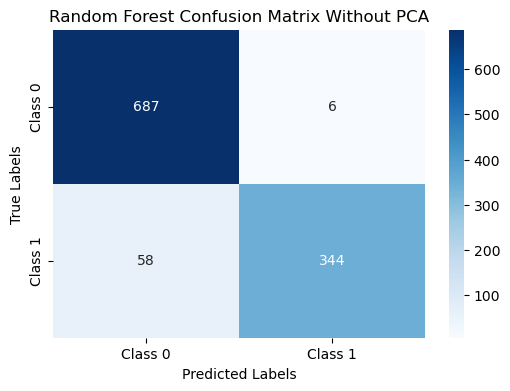

In [18]:
# Random Forest without PCA
print("\nRandom Forest - Without PCA:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_trained, X_train, X_test, y_train, y_test = train_data(
    data, rf_model, label_col=label_column, standardize=False, with_pca=False
)
rf_results_no_pca, rf_confusion_no_pca = evaluate(rf_trained, X_test, y_test)
print(rf_results_no_pca)
results.append({"Model": "Random Forest", "With PCA": False, **dict(zip(rf_results_no_pca["Metric"], rf_results_no_pca["Value"]))})
plot_confusion_matrix(rf_confusion_no_pca, labels=["Class 0", "Class 1"], title="Random Forest Confusion Matrix Without PCA")

## Random Forest with PCA


Random Forest - With PCA:
Training RandomForestClassifier...
              Metric     Value
0           Accuracy  0.941553
1  Balanced Accuracy  0.930844
2           F1 Score  0.917949
3                AUC  0.982460


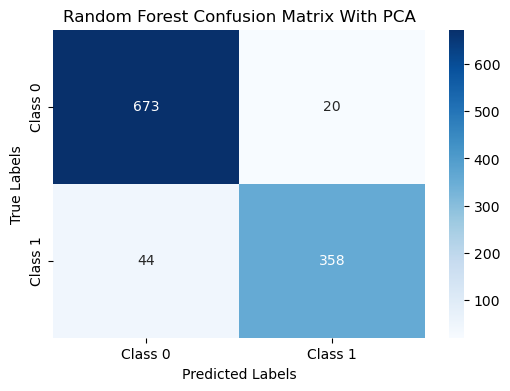

In [19]:
# Random Forest with PCA
print("\nRandom Forest - With PCA:")
rf_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, rf_model, label_col=label_column, standardize=False, with_pca=True, n_pca_components=10
)
rf_results_pca, rf_confusion_pca = evaluate(rf_trained_pca, X_test_pca, y_test_pca)
print(rf_results_pca)
results.append({"Model": "Random Forest", "With PCA": True, **dict(zip(rf_results_pca["Metric"], rf_results_pca["Value"]))})
plot_confusion_matrix(rf_confusion_pca, labels=["Class 0", "Class 1"], title="Random Forest Confusion Matrix With PCA")

## SVM without PCA


Support Vector Machine (SVM) - Without PCA:
Training SVC...
              Metric     Value
0           Accuracy  0.964384
1  Balanced Accuracy  0.953582
2           F1 Score  0.949547
3                AUC  0.992598


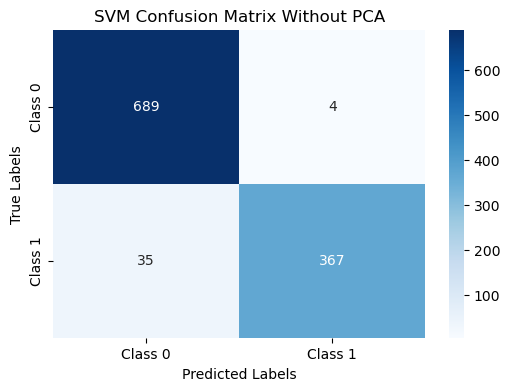

In [20]:
# SVM without PCA
print("\nSupport Vector Machine (SVM) - Without PCA:")
svm_model = SVC(probability=True)
svm_trained, X_train, X_test, y_train, y_test = train_data(
    data, svm_model, label_col=label_column, standardize=True, with_pca=False
)
svm_results_no_pca, svm_confusion_no_pca = evaluate(svm_trained, X_test, y_test)
print(svm_results_no_pca)
results.append({"Model": "SVM", "With PCA": False, **dict(zip(svm_results_no_pca["Metric"], svm_results_no_pca["Value"]))})
plot_confusion_matrix(svm_confusion_no_pca, labels=["Class 0", "Class 1"], title="SVM Confusion Matrix Without PCA")

## SVM with PCA


Support Vector Machine (SVM) - With PCA:
Training SVC...
              Metric     Value
0           Accuracy  0.960731
1  Balanced Accuracy  0.952785
2           F1 Score  0.945223
3                AUC  0.992379


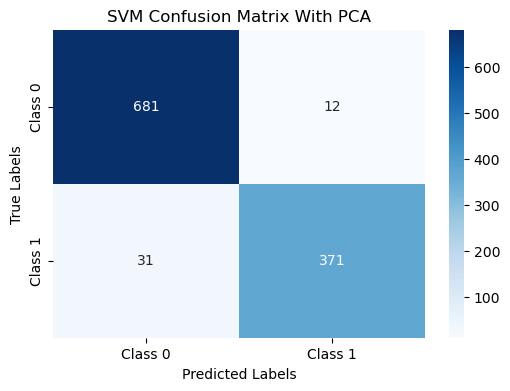

In [21]:
# SVM with PCA
print("\nSupport Vector Machine (SVM) - With PCA:")
svm_trained_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_data(
    data, svm_model, label_col=label_column, standardize=True, with_pca=True, n_pca_components=10
)
svm_results_pca, svm_confusion_pca = evaluate(svm_trained_pca, X_test_pca, y_test_pca)
print(svm_results_pca)
results.append({"Model": "SVM", "With PCA": True, **dict(zip(svm_results_pca["Metric"], svm_results_pca["Value"]))})
plot_confusion_matrix(svm_confusion_pca, labels=["Class 0", "Class 1"], title="SVM Confusion Matrix With PCA")


## Printint all the results

In [22]:
results_df = pd.DataFrame(results)

### Printing all results without PCA

In [23]:
results_df.loc[results_df["With PCA"]==False, :]

,Model,With PCA,Accuracy,Balanced Accuracy,F1 Score,AUC
0,LDA,False,0.700457,0.700674,0.632287,0.738854
2,Logistic Regression,False,0.953425,0.950146,0.936646,0.991995
4,QDA,False,0.529680,0.541206,0.477157,0.541206
6,k-NN,False,0.729680,0.666834,0.538941,0.714191
8,GBDT,False,0.948858,0.937660,0.927835,0.989834
10,Random Forest,False,0.941553,0.923532,0.914894,0.989892
12,SVM,False,0.964384,0.953582,0.949547,0.992598


### Printing all results with PCA

In [24]:
results_df.loc[results_df["With PCA"]==True, :]

,Model,With PCA,Accuracy,Balanced Accuracy,F1 Score,AUC
1,LDA,True,0.943379,0.924452,0.917112,0.989849
3,Logistic Regression,True,0.960731,0.954874,0.945776,0.991586
5,QDA,True,0.953425,0.945446,0.935197,0.989687
7,k-NN,True,0.931507,0.914551,0.901186,0.971486
9,GBDT,True,0.940639,0.929078,0.916345,0.984665
11,Random Forest,True,0.941553,0.930844,0.917949,0.982460
13,SVM,True,0.960731,0.952785,0.945223,0.992379


# Task 1.2 Hyperparameter tuning workflow related functions

### Workflow related functions for each model hyperparameter tuning

#### Split data

In [38]:
def train_split(data, label_col, random_state=42, test_size=0.2):
    """
    Splits the dataset into training and testing sets without preprocessing.
    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


#### Create Pipeline

In [39]:
def create_pipeline(model, model_name, standardize=False, with_pca=False, n_pca_components=10):
    """
    Creates a pipeline for a given model with optional standardization and PCA.
    """
    steps = []
    if standardize:
        steps.append(('scaler', StandardScaler()))
    if with_pca:
        steps.append(('pca', PCA(n_components=n_pca_components)))

    if "random_state" in model.get_params():
        model.set_params(random_state=42)

    steps.append((model_name, model))
    return Pipeline(steps)


#### Hyperparameter tuning for a single model

In [40]:
def grid_search_tuning(model_name, config, X_train, y_train, scoring="f1", cv_folds=5, n_jobs=-1):
    """
    Perform hyperparameter tuning for a model pipeline using GridSearchCV.
    """
    pipeline = create_pipeline(
        model=config["model"],
        model_name=model_name,
        standardize=config["preprocess"].get("standardize", False),
        with_pca=config["preprocess"].get("pca", False),
        n_pca_components=config["preprocess"].get("pca_components", 10)
    )
    pipeline.set_params(**config["fixed_params"])
    
    # Grid Search Configuration
    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["grid_search_params"],
        scoring=scoring,
        # Cross-validation with fixed random state
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        n_jobs=n_jobs,
        verbose=0
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    elapsed_time = (time.time() - start_time) / 60
    
    # Save Best Parameters and Results
    best_params = grid_search.best_params_
    best_params["MODEL_NAME"] = model_name
    best_params["TIME_ELAPSED_MIN"] = elapsed_time

    # Convert non-serializable objects in best_params to strings
    for key, value in best_params.items():
        if not isinstance(value, (str, int, float, list, dict, bool, type(None))):
            best_params[key] = str(value)

    full_results = pd.DataFrame(grid_search.cv_results_)
    full_results.to_csv(f"Tuning_params/{model_name}_all_results.csv", index=False)

    with open(f"Tuning_params/{model_name}_best_params.json", "w") as f:
        json.dump(best_params, f, indent=4)

    print(f"Model {model_name} tuned in {elapsed_time:.2f} minutes")
    return grid_search, best_params


#### Summarize best parameter for the model

In [41]:
def summarize_best_parameters(results_dir="Tuning_params", model_names=[]):
    """
    Summarizes the best parameters for all models from their JSON files.
    """
    best_params_summary = []

    for model_name in model_names:
        try:
            # Read best parameters JSON
            with open(f"{results_dir}/{model_name}_best_params.json", "r") as f:
                best_params = json.load(f)

            # Check and ensure that random_state is consistently included where applicable
            if "random_state" not in best_params:
                print(f"Warning: 'random_state' not found for model {model_name}. Ensure pipeline enforces it.")
            
            # Append model's best parameters to the summary list
            summary_entry = {
                "Model Name": model_name,
                **{k: v for k, v in best_params.items() if "__" in k},  # Add hyperparameters
                "Time Elapsed (min)": best_params.get("TIME_ELAPSED_MIN", "N/A")
            }

            # Add reproducibility info
            if "random_state" in best_params:
                summary_entry["Random State"] = best_params["random_state"]
            else:
                summary_entry["Random State"] = "Not Applicable"
            
            
            # Append model's best parameters to the summary list
            best_params_summary.append(summary_entry)

        except Exception as e:
            print(f"Error loading best parameters for {model_name}: {e}")
            best_params_summary.append({"Model Name": model_name, "Error": str(e)})

    # Convert summary to DataFrame
    best_params_df = pd.DataFrame(best_params_summary)
    best_params_df.to_csv("best_parameters_summary.csv", index=False)  # Save to CSV for reference
    print("Best parameters summary saved to best_parameters_summary.csv.")
    return best_params_df


#### Evaluate optimised Model

In [42]:
def evaluate_optimized_model(model_name, model_config, results_dir, X_train, X_test, y_train, y_test, plot_final_confusion=True):
    """
    Evaluates the performance of a single optimized model and saves results.
    """
    try:
        # Load Best Parameters
        with open(f"{results_dir}/{model_name}_best_params.json", "r") as f:
            best_params = json.load(f)
        
        # Ensure random_state is consistent across all steps
        if "random_state" in model_config["model"].get_params():
            model_config["model"].set_params(random_state=42)
        
        pipeline_params = {k: v for k, v in best_params.items() if "__" in k}

        # Create Pipeline
        pipeline = create_pipeline(
            model=model_config["model"],
            model_name=model_name,
            standardize=model_config["preprocess"].get("standardize", False),
            with_pca=model_config["preprocess"].get("pca", False),
            n_pca_components=model_config["preprocess"].get("pca_components", 10)
        )
        pipeline.set_params(**pipeline_params)

        # Fit Pipeline to Training Data
        pipeline.fit(X_train, y_train)

        # Evaluate on Test Data
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]) if hasattr(pipeline, "predict_proba") else None
        confusion = confusion_matrix(y_test, y_pred)

        # Plot Confusion Matrix (for final model)
        if plot_final_confusion:
            labels = sorted(np.unique(y_test))  # Ensure proper label alignment
            plot_confusion_matrix(confusion, labels, title=f"{model_name} Final Confusion Matrix")

        results = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Balanced Accuracy": balanced_accuracy,
            "AUC": auc_score,
            "F1 Score": f1,
            "Confusion Matrix": confusion.tolist()
        }

        # Save Results
        pd.DataFrame([results]).to_csv(f"{results_dir}/{model_name}_evaluation_summary.csv", index=False)
        print(f"Evaluation results for {model_name} saved.")
        return results
    except Exception as e:
        print(f"Error evaluating model {model_name}: {e}")
        return {"Model": model_name, "Error": str(e)}


## Tuning stage (No PCA)

### Tuning LDA

Model lda tuned in 5.62 minutes


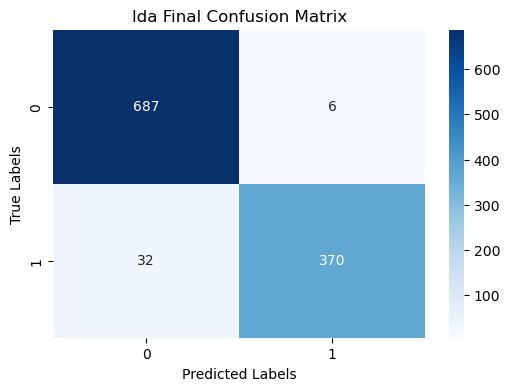

Evaluation results for lda saved.
{'Model': 'lda', 'Accuracy': 0.965296803652968, 'Balanced Accuracy': 0.95587000064612, 'AUC': 0.9932336872635381, 'F1 Score': 0.9511568123393316, 'Confusion Matrix': [[687, 6], [32, 370]]}


In [43]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# LDA Configuration
lda_config = {
    "model": LinearDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"lda__tol": 0.0001},
    "grid_search_params": [
        {"lda__solver": ["svd"]},
        {"lda__solver": ["lsqr"], "lda__shrinkage": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "auto"]}
    ]
}

# Tune LDA
lda_results = grid_search_tuning("lda", lda_config, X_train, y_train)

# Evaluate LDA
lda_eval = evaluate_optimized_model("lda", lda_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(lda_eval)


### Tuning logistic

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Logistic Regression Configuration
logit_config = {
    "model": LogisticRegression(random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "logit__max_iter": 100,
        "logit__solver": "saga",
        "logit__n_jobs": -1,
        "logit__penalty": "elasticnet"
    },
    "grid_search_params": {
        "logit__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
        "logit__l1_ratio": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "logit__class_weight": [None, "balanced"]
    }
}

# Tune Logistic Regression
logit_results = grid_search_tuning("logit", logit_config, X_train, y_train)

# Evaluate Logistic Regression
logit_eval = evaluate_optimized_model("logit", logit_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(logit_eval)


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-pack

### Tuning QDA

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  war

Model qda tuned in 1.89 minutes.


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


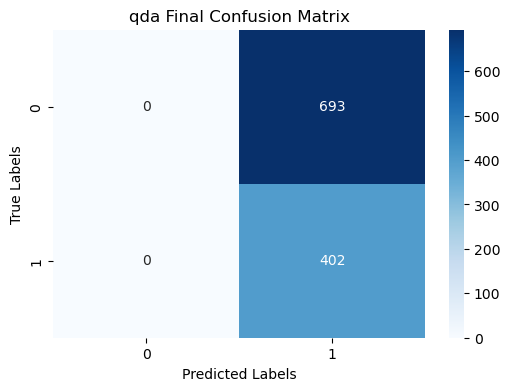

Evaluation results for qda saved.
{'Model': 'qda', 'Accuracy': 0.36712328767123287, 'Balanced Accuracy': 0.5, 'AUC': 0.5, 'F1 Score': 0.5370741482965932, 'Confusion Matrix': [[0, 693], [0, 402]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# QDA Configuration
qda_config = {
    "model": QuadraticDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"qda__priors": None},
    "grid_search_params": {
        "qda__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
}

# Tune QDA
qda_results = grid_search_tuning("qda", qda_config, X_train, y_train)

# Evaluate QDA
qda_eval = evaluate_optimized_model("qda", qda_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(qda_eval)


### Tuning K-nn

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/neighbors/_base.py:653: UserWarning: Mind that for 0 < p < 1, Minkowski metrics are not distance metrics. Continuing the execution with `algorithm='brute'`.
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packag

Model knn tuned in 114.53 minutes.


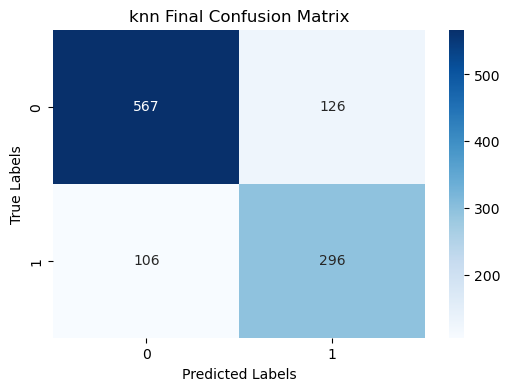

Evaluation results for knn saved.
{'Model': 'knn', 'Accuracy': 0.7881278538812785, 'Balanced Accuracy': 0.7772501130710086, 'AUC': 0.8737553215165156, 'F1 Score': 0.7184466019417476, 'Confusion Matrix': [[567, 126], [106, 296]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# KNN Configuration
knn_config = {
    "model": KNeighborsClassifier(),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "knn__metric": "minkowski",
        "knn__n_jobs": 1
    },
    "grid_search_params": {
        "knn__p": [0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.2, 3.0, 10.0],
        "knn__weights": ["uniform", "distance"],
        "knn__n_neighbors": [1, 3, 5, 9, 11, 15, 20, 30]
    }
}

# Tune KNN
knn_results = grid_search_tuning("knn", knn_config, X_train, y_train)

# Evaluate KNN
knn_eval = evaluate_optimized_model("knn", knn_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(knn_eval)


### Tuning SVM

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# SVM Configuration
svm_config = {
    "model": SVC(probability=True, random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {"svm__degree": 3},
    "grid_search_params": {
        "svm__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001, 5, 10],
        "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "svm__gamma": ["scale", "auto"],
        "svm__class_weight": [None, "balanced"]
    }
}

# Tune SVM
svm_results = grid_search_tuning("svm", svm_config, X_train, y_train)

# Evaluate SVM
svm_eval = evaluate_optimized_model("svm", svm_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(svm_eval)


/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### Tuning Random forest

Model rf tuned in 1.68 minutes.


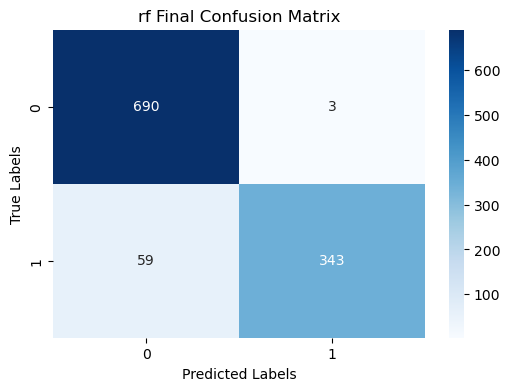

Evaluation results for rf saved.
{'Model': 'rf', 'Accuracy': 0.94337899543379, 'Balanced Accuracy': 0.9244524132583833, 'AUC': 0.9925552612119776, 'F1 Score': 0.9171122994652406, 'Confusion Matrix': [[690, 3], [59, 343]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Random Forest Configuration
rf_config = {
    "model": RandomForestClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": False},
    "fixed_params": {"rf__bootstrap": True},
    "grid_search_params": {
        "rf__n_estimators": [100, 200, 300, 400],
        "rf__criterion": ["gini", "entropy"],
        "rf__max_features": ["sqrt", "log2"]
    }
}

# Tune Random Forest
rf_results = grid_search_tuning("rf", rf_config, X_train, y_train)

# Evaluate Random Forest
rf_eval = evaluate_optimized_model("rf", rf_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(rf_eval)


### Tuning Gradient Boosting

Model gbdt tuned in 17.62 minutes.


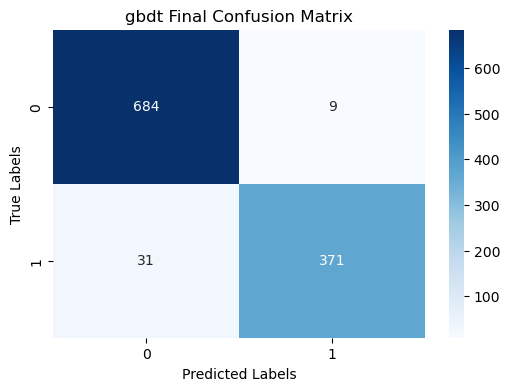

Evaluation results for gbdt saved.
{'Model': 'gbdt', 'Accuracy': 0.9634703196347032, 'Balanced Accuracy': 0.9549492795761452, 'AUC': 0.9942997853445615, 'F1 Score': 0.948849104859335, 'Confusion Matrix': [[684, 9], [31, 371]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Gradient Boosting Configuration
gbdt_config = {
    "model": GradientBoostingClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": False},
    "fixed_params": {
        "gbdt__loss": "log_loss",
        "gbdt__n_iter_no_change": 15
    },
    "grid_search_params": {
        "gbdt__n_estimators": [100, 200, 300, 400, 500],
        "gbdt__max_depth": [1, 3, 5, 7, 9],
        "gbdt__learning_rate": [0.1, 0.05, 0.2, 0.3],
        "gbdt__max_features": ["sqrt", 100, 130]
    }
}

# Tune Gradient Boosting
gbdt_results = grid_search_tuning("gbdt", gbdt_config, X_train, y_train)

# Evaluate Gradient Boosting
gbdt_eval = evaluate_optimized_model("gbdt", gbdt_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(gbdt_eval)


#### Combine evaluation results for all models without PCA (after completion)

In [ ]:
# Combine all evaluation results into a single DataFrame
final_results = pd.DataFrame([
    lda_eval, 
    logit_eval, 
    qda_eval, 
    knn_eval, 
    svm_eval, 
    rf_eval, 
    gbdt_eval
])

# Save the combined results to a CSV
final_results.to_csv("no_pca_results.csv", index=False)

# Display the final results
final_results

,Model,Accuracy,Balanced Accuracy,AUC,F1 Score,Confusion Matrix
0,lda,0.965297,0.955870,0.993234,0.951157,"[[687, 6], [32, 370]]"
1,logit,0.957991,0.953754,0.993485,0.942500,"[[672, 21], [25, 377]]"
2,qda,0.367123,0.500000,0.500000,0.537074,"[[0, 693], [0, 402]]"
3,knn,0.788128,0.777250,0.873755,0.718447,"[[567, 126], [106, 296]]"
4,svm,0.956164,0.952833,NaN,0.940299,"[[669, 24], [24, 378]]"
5,rf,0.943379,0.924452,0.992555,0.917112,"[[690, 3], [59, 343]]"
6,gbdt,0.963470,0.954949,0.994300,0.948849,"[[684, 9], [31, 371]]"


## Tuning stage with PCA

### LDA with PCA

Model lda_pca tuned in 0.14 minutes.


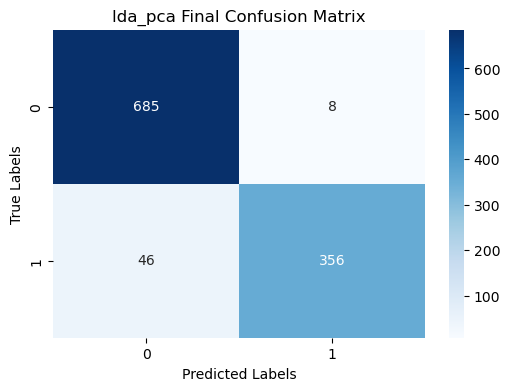

Evaluation results for lda_pca saved.


{'Model': 'lda_pca',
 'Accuracy': 0.9506849315068493,
 'Balanced Accuracy': 0.9370140638797355,
 'AUC': 0.993599821958031,
 'F1 Score': 0.9295039164490861,
 'Confusion Matrix': [[685, 8], [46, 356]]}

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# LDA Configuration with PCA
lda_pca_config = {
    "model": LinearDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": True},  # Enable PCA
    "fixed_params": {"lda_pca__tol": 0.0001},
    "grid_search_params": [
        {"lda_pca__solver": ["svd"], "pca__n_components": [5, 10, 20]},
        {"lda_pca__solver": ["lsqr"], "lda_pca__shrinkage": [0.0, 0.1, 0.5, "auto"], "pca__n_components": [5, 10, 20]}
    ]
}

# Tune LDA with PCA
lda_pca_results = grid_search_tuning("lda_pca", lda_pca_config, X_train, y_train)

# Evaluate LDA with PCA
lda_pca_eval = evaluate_optimized_model("lda_pca", lda_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

lda_pca_eval


### Logistic Regression with PCA

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model logit_pca tuned in 0.71 minutes.


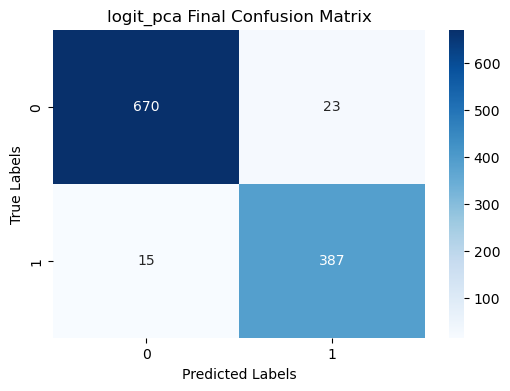

Evaluation results for logit_pca saved.


{'Model': 'logit_pca',
 'Accuracy': 0.965296803652968,
 'Balanced Accuracy': 0.964748766987573,
 'AUC': 0.9942567106746212,
 'F1 Score': 0.9532019704433498,
 'Confusion Matrix': [[670, 23], [15, 387]]}

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Logistic Regression Configuration with PCA
logit_pca_config = {
    "model": LogisticRegression(random_state=42),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {
        "logit_pca__max_iter": 100,
        "logit_pca__solver": "saga",
        "logit_pca__n_jobs": -1,
        "logit_pca__penalty": "elasticnet"
    },
    "grid_search_params": {
        "logit_pca__C": [0.01, 0.1, 1, 10],
        "logit_pca__l1_ratio": [0.1, 0.5, 0.9],
        "logit_pca__class_weight": [None, "balanced"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Logistic Regression with PCA
logit_pca_results = grid_search_tuning("logit_pca", logit_pca_config, X_train, y_train)

# Evaluate Logistic Regression with PCA
logit_pca_eval = evaluate_optimized_model("logit_pca", logit_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

logit_pca_eval


### QDA with PCA

Model qda_pca tuned in 0.15 minutes.


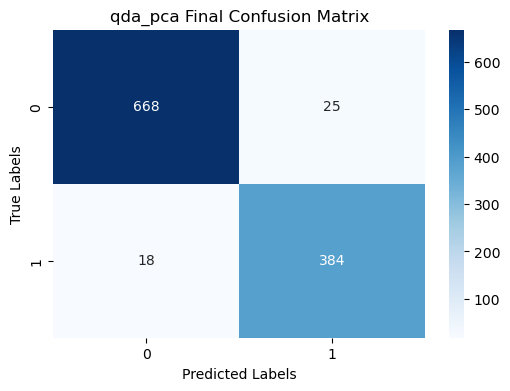

Evaluation results for qda_pca saved.


{'Model': 'qda_pca',
 'Accuracy': 0.960730593607306,
 'Balanced Accuracy': 0.9595744222609894,
 'AUC': 0.9934382919457547,
 'F1 Score': 0.9469790382244143,
 'Confusion Matrix': [[668, 25], [18, 384]]}

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# QDA Configuration with PCA
qda_pca_config = {
    "model": QuadraticDiscriminantAnalysis(),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {"qda_pca__priors": None},
    "grid_search_params": {
        "qda_pca__reg_param": [0.0, 0.1, 0.5, 1.0],
        "pca__n_components": [5, 10, 20]
    }
}


# Tune QDA with PCA
qda_pca_results = grid_search_tuning("qda_pca", qda_pca_config, X_train, y_train)

# Evaluate QDA with PCA
qda_pca_eval = evaluate_optimized_model("qda_pca", qda_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

qda_pca_eval


### K-nn with PCA

Model knn_pca tuned in 0.31 minutes.


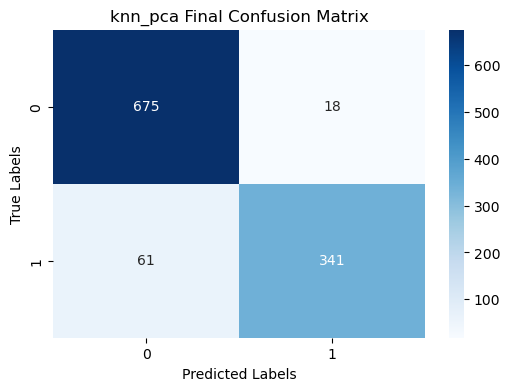

Evaluation results for knn_pca saved.


{'Model': 'knn_pca',
 'Accuracy': 0.9278538812785389,
 'Balanced Accuracy': 0.9111423402468178,
 'AUC': 0.9575624762191925,
 'F1 Score': 0.8961892247043364,
 'Confusion Matrix': [[675, 18], [61, 341]]}

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# KNN Configuration with PCA
knn_pca_config = {
    "model": KNeighborsClassifier(),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {
        "knn_pca__metric": "minkowski",
        "knn_pca__n_jobs": 1
    },
    "grid_search_params": {
        "knn_pca__p": [1, 2],  # Manhattan and Euclidean distances
        "knn_pca__weights": ["uniform", "distance"],
        "knn_pca__n_neighbors": [3, 5, 10],  # Common choices for neighbors
        "pca__n_components": [5, 10, 20]  # Reduced dimensions
    }
}

# Tune KNN with PCA
knn_pca_results = grid_search_tuning("knn_pca", knn_pca_config, X_train, y_train)

# Evaluate KNN with PCA
knn_pca_eval = evaluate_optimized_model("knn_pca", knn_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

knn_pca_eval


### SVM with PCA

Model svm_pca tuned in 0.93 minutes.


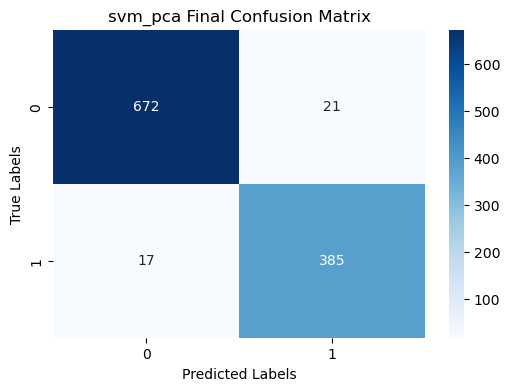

Evaluation results for svm_pca saved.


{'Model': 'svm_pca',
 'Accuracy': 0.965296803652968,
 'Balanced Accuracy': 0.9637042062415198,
 'AUC': None,
 'F1 Score': 0.9529702970297029,
 'Confusion Matrix': [[672, 21], [17, 385]]}

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# SVM Configuration with PCA
svm_pca_config = {
    "model": SVC(probability=True, random_state=42),
    "preprocess": {"standardize": True, "pca": True},
    "fixed_params": {"svm_pca__degree": 3},  # Use 'svm_pca__' to match pipeline step name
    "grid_search_params": {
        "svm_pca__C": [0.1, 1, 10],
        "svm_pca__kernel": ["linear", "rbf"],
        "svm_pca__gamma": ["scale", "auto"],
        "svm_pca__class_weight": [None, "balanced"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune SVM with PCA
svm_pca_results = grid_search_tuning("svm_pca", svm_pca_config, X_train, y_train)

# Evaluate SVM with PCA
svm_pca_eval = evaluate_optimized_model("svm_pca", svm_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

svm_pca_eval


### RF with PCA

Model rf_pca tuned in 0.74 minutes.


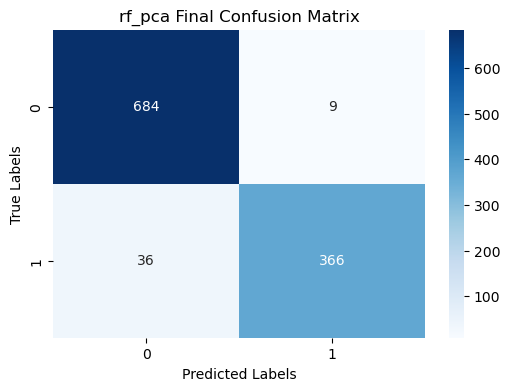

Evaluation results for rf_pca saved.
{'Model': 'rf_pca', 'Accuracy': 0.958904109589041, 'Balanced Accuracy': 0.9487303741035085, 'AUC': 0.9889046829345336, 'F1 Score': 0.9420849420849421, 'Confusion Matrix': [[684, 9], [36, 366]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Random Forest Configuration with PCA
rf_pca_config = {
    "model": RandomForestClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": True},
    "fixed_params": {"rf_pca__bootstrap": True},  # Correct parameter prefix
    "grid_search_params": {
        "rf_pca__n_estimators": [100, 200, 300],
        "rf_pca__criterion": ["gini", "entropy"],
        "rf_pca__max_features": ["sqrt", "log2"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Random Forest with PCA
rf_pca_results = grid_search_tuning("rf_pca", rf_pca_config, X_train, y_train)

# Evaluate Random Forest with PCA
rf_pca_eval = evaluate_optimized_model("rf_pca", rf_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(rf_pca_eval)


### GBDT with PCA

Model gbdt_pca tuned in 1.19 minutes.


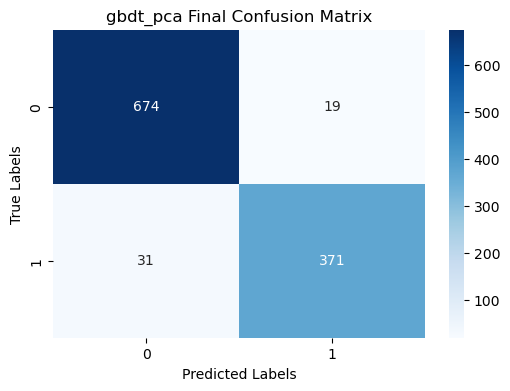

Evaluation results for gbdt_pca saved.
{'Model': 'gbdt_pca', 'Accuracy': 0.954337899543379, 'Balanced Accuracy': 0.9477342723611379, 'AUC': 0.9903476843775351, 'F1 Score': 0.9368686868686869, 'Confusion Matrix': [[674, 19], [31, 371]]}


In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Gradient Boosting Configuration with PCA
gbdt_pca_config = {
    "model": GradientBoostingClassifier(random_state=42),
    "preprocess": {"standardize": False, "pca": True},
    "fixed_params": {"gbdt_pca__loss": "log_loss", "gbdt_pca__n_iter_no_change": 15},  # Correct parameter prefix
    "grid_search_params": {
        "gbdt_pca__n_estimators": [100, 200],
        "gbdt_pca__max_depth": [3, 5],
        "gbdt_pca__learning_rate": [0.05, 0.1, 0.2],
        "gbdt_pca__max_features": ["sqrt", 100],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Gradient Boosting with PCA
gbdt_pca_results = grid_search_tuning("gbdt_pca", gbdt_pca_config, X_train, y_train)

# Evaluate Gradient Boosting with PCA
gbdt_pca_eval = evaluate_optimized_model("gbdt_pca", gbdt_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

print(gbdt_pca_eval)


In [ ]:
# Combine PCA evaluation results into a single DataFrame
pca_results = pd.DataFrame([
    lda_pca_eval, 
    logit_pca_eval, 
    qda_pca_eval, 
    knn_pca_eval, 
    svm_pca_eval, 
    rf_pca_eval, 
    gbdt_pca_eval
])

# Save the PCA-only results to a CSV
pca_results.to_csv("pca_results.csv", index=False)

# Display the PCA-only results
print(pca_results)

       Model  Accuracy  Balanced Accuracy       AUC  F1 Score  \
0    lda_pca  0.950685           0.937014  0.993600  0.929504   
1  logit_pca  0.965297           0.964749  0.994257  0.953202   
2    qda_pca  0.960731           0.959574  0.993438  0.946979   
3    knn_pca  0.927854           0.911142  0.957562  0.896189   
4    svm_pca  0.965297           0.963704       NaN  0.952970   
5     rf_pca  0.958904           0.948730  0.988905  0.942085   
6   gbdt_pca  0.954338           0.947734  0.990348  0.936869   

         Confusion Matrix  
0   [[685, 8], [46, 356]]  
1  [[670, 23], [15, 387]]  
2  [[668, 25], [18, 384]]  
3  [[675, 18], [61, 341]]  
4  [[672, 21], [17, 385]]  
5   [[684, 9], [36, 366]]  
6  [[674, 19], [31, 371]]  


## Combining full results

In [ ]:
# Combine all evaluation results (standard + PCA) into a single DataFrame
final_results = pd.DataFrame([
    lda_eval, 
    lda_pca_eval, 
    logit_eval, 
    logit_pca_eval, 
    qda_eval, 
    qda_pca_eval, 
    knn_eval, 
    knn_pca_eval, 
    svm_eval, 
    svm_pca_eval, 
    rf_eval, 
    rf_pca_eval, 
    gbdt_eval, 
    gbdt_pca_eval
])

# Save the full results to a CSV
final_results.to_csv("final_results.csv", index=False)

# Display the full results
final_results

,Model,Accuracy,Balanced Accuracy,AUC,F1 Score,Confusion Matrix
0,lda,0.965297,0.955870,0.993234,0.951157,"[[687, 6], [32, 370]]"
1,lda_pca,0.950685,0.937014,0.993600,0.929504,"[[685, 8], [46, 356]]"
2,logit,0.957991,0.953754,0.993485,0.942500,"[[672, 21], [25, 377]]"
3,logit_pca,0.965297,0.964749,0.994257,0.953202,"[[670, 23], [15, 387]]"
4,qda,0.367123,0.500000,0.500000,0.537074,"[[0, 693], [0, 402]]"
5,qda_pca,0.960731,0.959574,0.993438,0.946979,"[[668, 25], [18, 384]]"
6,knn,0.788128,0.777250,0.873755,0.718447,"[[567, 126], [106, 296]]"
7,knn_pca,0.927854,0.911142,0.957562,0.896189,"[[675, 18], [61, 341]]"
8,svm,0.956164,0.952833,NaN,0.940299,"[[669, 24], [24, 378]]"
9,svm_pca,0.965297,0.963704,NaN,0.952970,"[[672, 21], [17, 385]]"


# Task 1.3

### Adaboost Without PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# AdaBoost Configuration without PCA
ada_boost_no_pca_config = {
    "model": AdaBoostClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": False},
    "fixed_params": {
        "ada_boost_no_pca__algorithm": "SAMME"
    },
    "grid_search_params": {
        "ada_boost_no_pca__estimator": [DecisionTreeClassifier(max_depth=2), LogisticRegression()],
        "ada_boost_no_pca__n_estimators": [50, 100, 200],
        "ada_boost_no_pca__learning_rate": [0.05, 0.1, 0.5, 1]
    }
}

# Tune AdaBoost without PCA
ada_boost_no_pca_results = grid_search_tuning("ada_boost_no_pca", ada_boost_no_pca_config, X_train, y_train)

# Evaluate AdaBoost without PCA
ada_boost_no_pca_eval = evaluate_optimized_model("ada_boost_no_pca", ada_boost_no_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
ada_boost_no_pca_eval

/opt/anaconda3/envs/ST443/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


TypeError: Object of type DecisionTreeClassifier is not JSON serializable

### Adaboost With PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# AdaBoost Configuration with PCA
ada_boost_pca_config = {
    "model": AdaBoostClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": True},  # Enable PCA
    "fixed_params": {
        "ada_boost_pca__algorithm": "SAMME"  # Correct parameter prefix for the pipeline
    },
    "grid_search_params": {
        "ada_boost_pca__estimator": [DecisionTreeClassifier(max_depth=2), LogisticRegression()],
        "ada_boost_pca__n_estimators": [50, 100, 200],
        "ada_boost_pca__learning_rate": [0.05, 0.1, 0.5, 1],
        "pca__n_components": [5, 10, 20]  # PCA dimensionality reduction
    }
}

# Tune AdaBoost with PCA
ada_boost_pca_results = grid_search_tuning("ada_boost_pca", ada_boost_pca_config, X_train, y_train)

# Evaluate AdaBoost with PCA
ada_boost_pca_eval = evaluate_optimized_model("ada_boost_pca", ada_boost_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
ada_boost_pca_eval

### Voting classifier without PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Voting Classifier without PCA
voting_no_pca_config = {
    "model": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('rf', RandomForestClassifier(random_state=42))
        ]
    ),
    "preprocess": {"standardize": True, "pca": False},  # PCA disabled
    "fixed_params": {},  # No fixed parameters specific to voting
    "grid_search_params": {
        "voting__voting": ["hard", "soft"]
    }
}

# Tune Voting Classifier without PCA
voting_no_pca_results = grid_search_tuning("voting_no_pca", voting_no_pca_config, X_train, y_train)

# Evaluate Voting Classifier without PCA
voting_no_pca_eval = evaluate_optimized_model("voting_no_pca", voting_no_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

voting_no_pca_results


### Voting classifier with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Voting Classifier with PCA
voting_pca_config = {
    "model": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('svm', SVC(probability=True, random_state=42)),
            ('rf', RandomForestClassifier(random_state=42))
        ]
    ),
    "preprocess": {"standardize": True, "pca": True},  # PCA enabled
    "fixed_params": {},  # No fixed parameters specific to voting
    "grid_search_params": {
        "voting__voting": ["hard", "soft"],
        "pca__n_components": [5, 10, 20]
    }
}

# Tune Voting Classifier with PCA
voting_pca_results = grid_search_tuning("voting_pca", voting_pca_config, X_train, y_train)

# Evaluate Voting Classifier with PCA
voting_pca_eval = evaluate_optimized_model("voting_pca", voting_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)


voting_pca_eval


### Bagging classifiers without PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Bagging Classifier
bagging_config = {
    "model": BaggingClassifier(random_state=42),
    "preprocess": {"standardize": True, "pca": False},  # PCA disabled
    "fixed_params": {"bagging__n_jobs": -1},  # Use all processors
    "grid_search_params": {
        "bagging__n_estimators": [10, 50, 100],
        "bagging__base_estimator": [DecisionTreeClassifier(max_depth=5), LogisticRegression()]
    }
}

# Tune Bagging
bagging_results = grid_search_tuning("bagging", bagging_config, X_train, y_train)

# Evaluate Bagging
bagging_eval = evaluate_optimized_model("bagging", bagging_config, "Tuning_params", X_train, X_test, y_train, y_test)


bagging_eval


### ElasticNet Logistic Regression with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# ElasticNet Logistic Regression with PCA
elasticnet_pca_config = {
    "model": LogisticRegression(penalty="elasticnet", solver="saga", random_state=42),
    "preprocess": {"standardize": True, "pca": True},  # PCA enabled
    "fixed_params": {"elasticnet__max_iter": 500},
    "grid_search_params": {
        "elasticnet__C": [0.01, 0.1, 1, 10],
        "elasticnet__l1_ratio": [0.1, 0.5, 0.9],
        "pca__n_components": [10, 25, 50]
    }
}

# Tune ElasticNet Logistic Regression with PCA
elasticnet_pca_results = grid_search_tuning("elasticnet_logit_pca", elasticnet_pca_config, X_train, y_train)

# Evaluate ElasticNet Logistic Regression with PCA
elasticnet_pca_eval = evaluate_optimized_model("elasticnet_logit_pca", elasticnet_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

# Print Evaluation Results
elasticnet_pca_eval


### StackingClassifier with PCA

In [ ]:
# Load Data
file_path = "Datasets/Data 1.csv.gz"
data = load_data(file_path)

# Split Data
X_train, X_test, y_train, y_test = train_split(data, label_col="label", random_state=42, test_size=0.2)

# Stacking Classifier with PCA
stacking_pca_config = {
    "model": StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(random_state=42)),
            ('rf', RandomForestClassifier(random_state=42)),
            ('svc', SVC(probability=True, random_state=42))
        ]
    ),
    "preprocess": {"standardize": True, "pca": True},  # PCA enabled
    "fixed_params": {},  # No fixed parameters specific to stacking
    "grid_search_params": {
        "stacking__final_estimator": [LogisticRegression(), GradientBoostingClassifier()],
        "pca__n_components": [10, 25, 50]
    }
}

# Tune Stacking
stacking_pca_results = grid_search_tuning("stacking_pca", stacking_pca_config, X_train, y_train)

# Evaluate Stacking
stacking_pca_eval = evaluate_optimized_model("stacking_pca", stacking_pca_config, "Tuning_params", X_train, X_test, y_train, y_test)

stacking_pca_eval


## Picking the best model

In [ ]:
# Combine all evaluation results into a single DataFrame
final_results = pd.DataFrame([
    ada_boost_no_pca_eval,
    ada_boost_pca_eval,     
    voting_no_pca_eval,      
    voting_pca_eval,         
    bagging_eval,             
    elasticnet_pca_eval,     
    stacking_pca_eval         
])

# Save the combined results to a CSV
final_results.to_csv("final_results_all_models.csv", index=False)

# Display the final results
final_results

## mypredict()